In [1]:
#!cd .. && mkdir build
#!cd ../build/ && rm -rf *
#!cd ../build && cmake \
#  -DPYTHON_EXECUTABLE="$(which python)" \
#  -DCMAKE_BUILD_TYPE=Release ..
#!cd ../build && make install

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from itertools import cycle
import metnum
import utils

In [5]:
readDF = shuffle(pd.read_csv('../data/train.csv'), random_state = 120)
DF_TEST = readDF[0:72000].copy()
df = readDF[72000:].copy()

In [6]:
readDF.describe()

id     antiguedad   habitaciones        garages  \
count  240000.000000  196445.000000  217529.000000  202235.000000   
mean   149969.382092       8.116114       2.902326       1.546874   
std     86634.579744       9.553830       0.896894       0.853507   
min         1.000000       0.000000       1.000000       0.000000   
25%     74930.750000       0.000000       2.000000       1.000000   
50%    149875.500000       5.000000       3.000000       2.000000   
75%    225016.500000      10.000000       3.000000       2.000000   
max    299999.000000      80.000000      10.000000       3.000000   

               banos  metroscubiertos  metrostotales        idzona  \
count  213779.000000    222600.000000  188533.000000  2.113790e+05   
mean        2.132417       174.016774     176.765145  2.423468e+06   
std         0.912546        98.152950      94.427328  1.056794e+07   
min         1.000000        15.000000      15.000000  2.200000e+01   
25%         1.000000        90.000000     102.000000  2.489000e+04   
50%         2.000000       153.000000     155.000000  5.638300e+04   
75%         3.000000       240.000000     238.000000  8.783800e+04   
max         4.000000       439.000000     439.000000  5.000400e+07   

                 lat            lng       gimnasio  usosmultiples  \
count  116512.000000  116512.000000  240000.000000  240000.000000   
mean       20.696818     -99.509221       0.062475       0.055092   
std         3.137884       9.744143       0.242017       0.228160   
min      -100.886679    -125.859375       0.000000       0.000000   
25%        19.359846    -100.977908       0.000000       0.000000   
50%        19.543273     -99.240387       0.000000       0.000000   
75%        20.740005     -99.134777       0.000000       0.000000   
max        83.026219     121.036000       1.000000       1.000000   

             piscina  escuelascercanas  centroscomercialescercanos  \
count  240000.000000     240000.000000               240000.000000   
mean        0.087383          0.444142                    0.396533   
std         0.282397          0.496871                    0.489179   
min         0.000000          0.000000                    0.000000   
25%         0.000000          0.000000                    0.000000   
50%         0.000000          0.000000                    0.000000   
75%         0.000000          1.000000                    1.000000   
max         1.000000          1.000000                    1.000000   

             precio  
count  2.400000e+05  
mean   2.530838e+06  
std    2.152552e+06  
min    3.100000e+05  
25%    9.527725e+05  
50%    1.850000e+06  
75%    3.390000e+06  
max    1.252500e+07

In [4]:
## Hacemos prediccion de cantidad de banos sobre el dataset completo

In [5]:
# Separamos las features de la cantidad de banos
df_completo_banos = df['banos'].copy()
df_completo_features = df.copy()
df_completo_features.pop('banos')

#Sacamos las features categoricas
df_completo_features = df_completo_features.select_dtypes(['float64'])
df_completo_features.pop('idzona')
print('Dataset listo!')

Dataset listo!


In [6]:
#Vemos que tan bien aproximamos la cantidad de banos con este modelo
utils.kFoldCrossValidation(df_completo_features,df_completo_banos)

[2.2004380125303022, 1.103340486949382]

<AxesSubplot:>

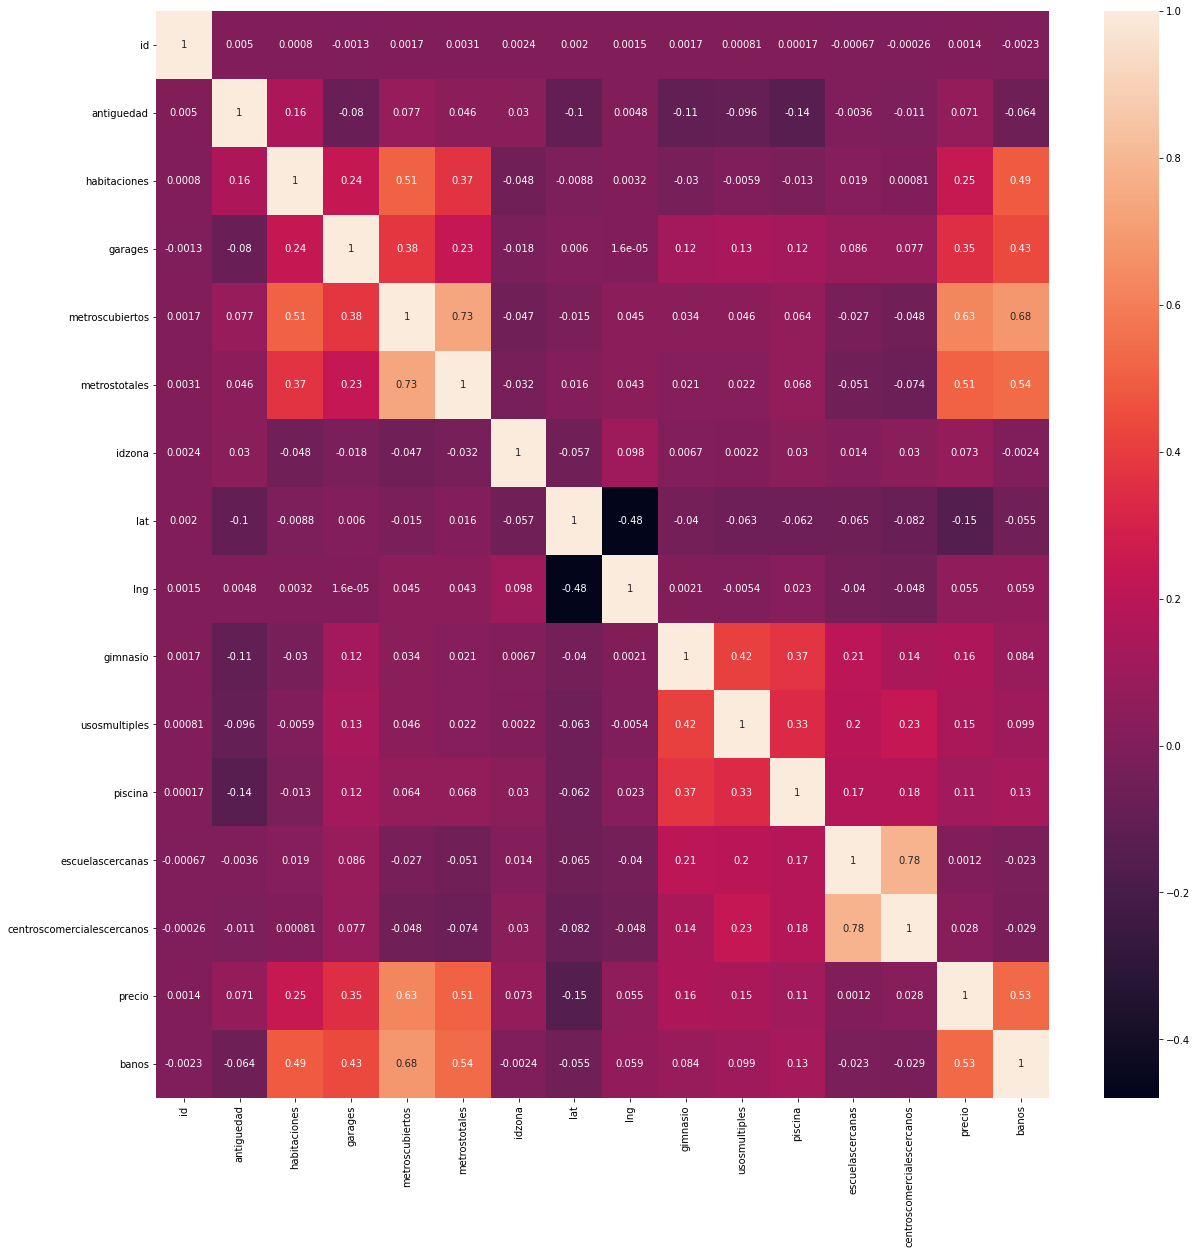

In [35]:
#Pasamos a ver la correlacion de las variables
tmp = df['banos'].copy()
df.pop('banos')
df['banos'] = tmp
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot = True)

In [8]:
#Corro el modelo usando las features con mas de (>=0.4) de correlacion
utils.kFoldCrossValidation(df_completo_features[['habitaciones','garages','metroscubiertos','metrostotales','precio']],df_completo_banos)

[2.253074991687388, 1.1194692791706968]

In [9]:
#Ahora usamos LASSO para ver que features nos sugiere

In [10]:
#Preparamos el dataset para usar LASSO
#Nos quedamos solo con las no categoricas y dropeo los NaN
df_lasso = df.select_dtypes('float64').copy().dropna()
df_lasso.pop('idzona')
df_lasso = df_lasso.dropna()
#Me guardo los banos y los features por separado
df_lasso_banos = df_lasso['banos']
df_lasso.pop('banos')
print('Listo para usar Lasso!')

Listo para usar Lasso!


-0.012084345387409962
0.0048943871517533955
0.0
0.006593317512939001
0.0005524531886991473
-0.0
-0.01077685338777462
0.0
0.0
0.0
0.0
0.0
9.926559676099788e-08


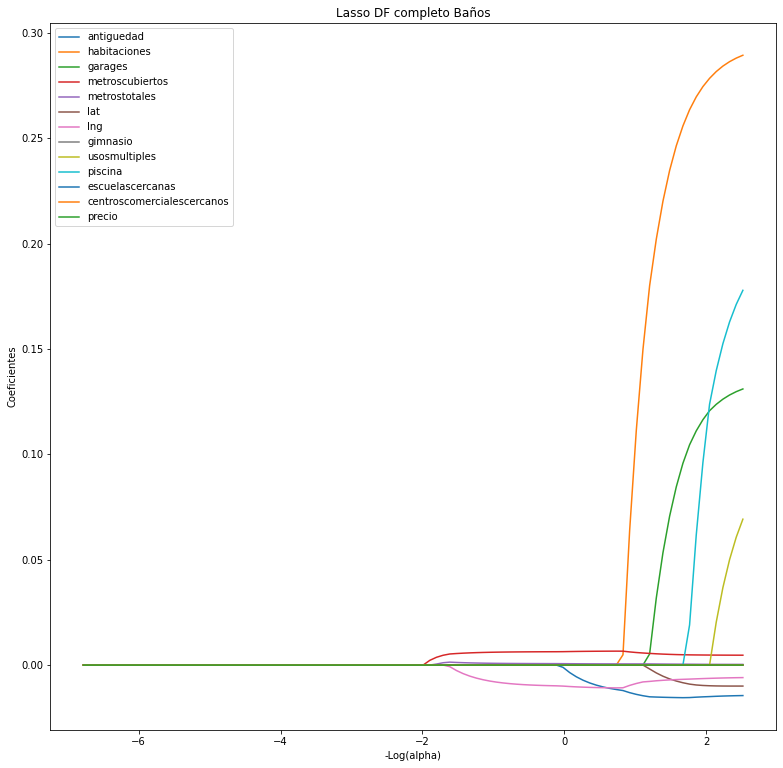

In [37]:
#Corremos Lasso para generar el path
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(df_lasso,df_lasso_banos / df_lasso_banos.std(axis=0),eps = 5e-10, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

#Seteo colores
colors = cycle(['black', 'black', 'black', 'blue', 'red', 'green', 'yellow', 'black', 'black', 'black', 'black', 'orange', 'purple'])
plt.figure(figsize=(13, 13))

#Me guardo los plots segun curva
lineas = []
for coef_l, c in zip(coefs_lasso, colors):
    lineas.append(plt.plot(neg_log_alphas_lasso, coef_l))
    print(coef_l[81])
    
#Hago el plot
plt.xlabel('-Log(alpha)')
plt.ylabel('Coeficientes')
plt.title('Lasso DF completo Baños')
plt.legend(df_lasso.columns.values)
plt.axis('tight')

plt.show()

In [38]:
#Nos quedamos con las 6 mejores features y corremos el modelo con estas
utils.kFoldCrossValidation(df_lasso[['metrostotales','precio','metroscubiertos','habitaciones','lng','antiguedad']],df_lasso_banos)

[0.5893475211815928, 0.19015320087577275]

In [13]:
#Creamos nuevas variables (Feature Engineering)

In [14]:
#Creamos dataset que contendra los features agregados
df_engineering = df.copy()

In [15]:
#Agregamos longitud de descripciones
df_engineering['longitud_descripciones'] = df_engineering.descripcion.str.split(' ').str.len()
DF_TEST['longitud_descripciones'] = DF_TEST.descripcion.str.split(' ').str.len()

In [16]:
#Agregamos rating familiar
df_engineering['rating_familiar'] = 2**( (df['habitaciones']) + (df['banos']) ) + 2 * df['metroscubiertos'] + 25 * df['escuelascercanas']
DF_TEST['rating_familiar'] = 2**( (DF_TEST['habitaciones']) + (DF_TEST['banos']) ) + 2 * DF_TEST['metroscubiertos'] + 25 * DF_TEST['escuelascercanas']

In [17]:
#Sacamos las categoricas
df_engineering = df_engineering.select_dtypes(['float64'])
df_engineering.pop('idzona')
tmp = df_engineering['banos'].copy()
df_engineering.pop('banos')
df_engineering['banos'] = tmp
print('Dataset listo para usar!')

Dataset listo para usar!


<AxesSubplot:>

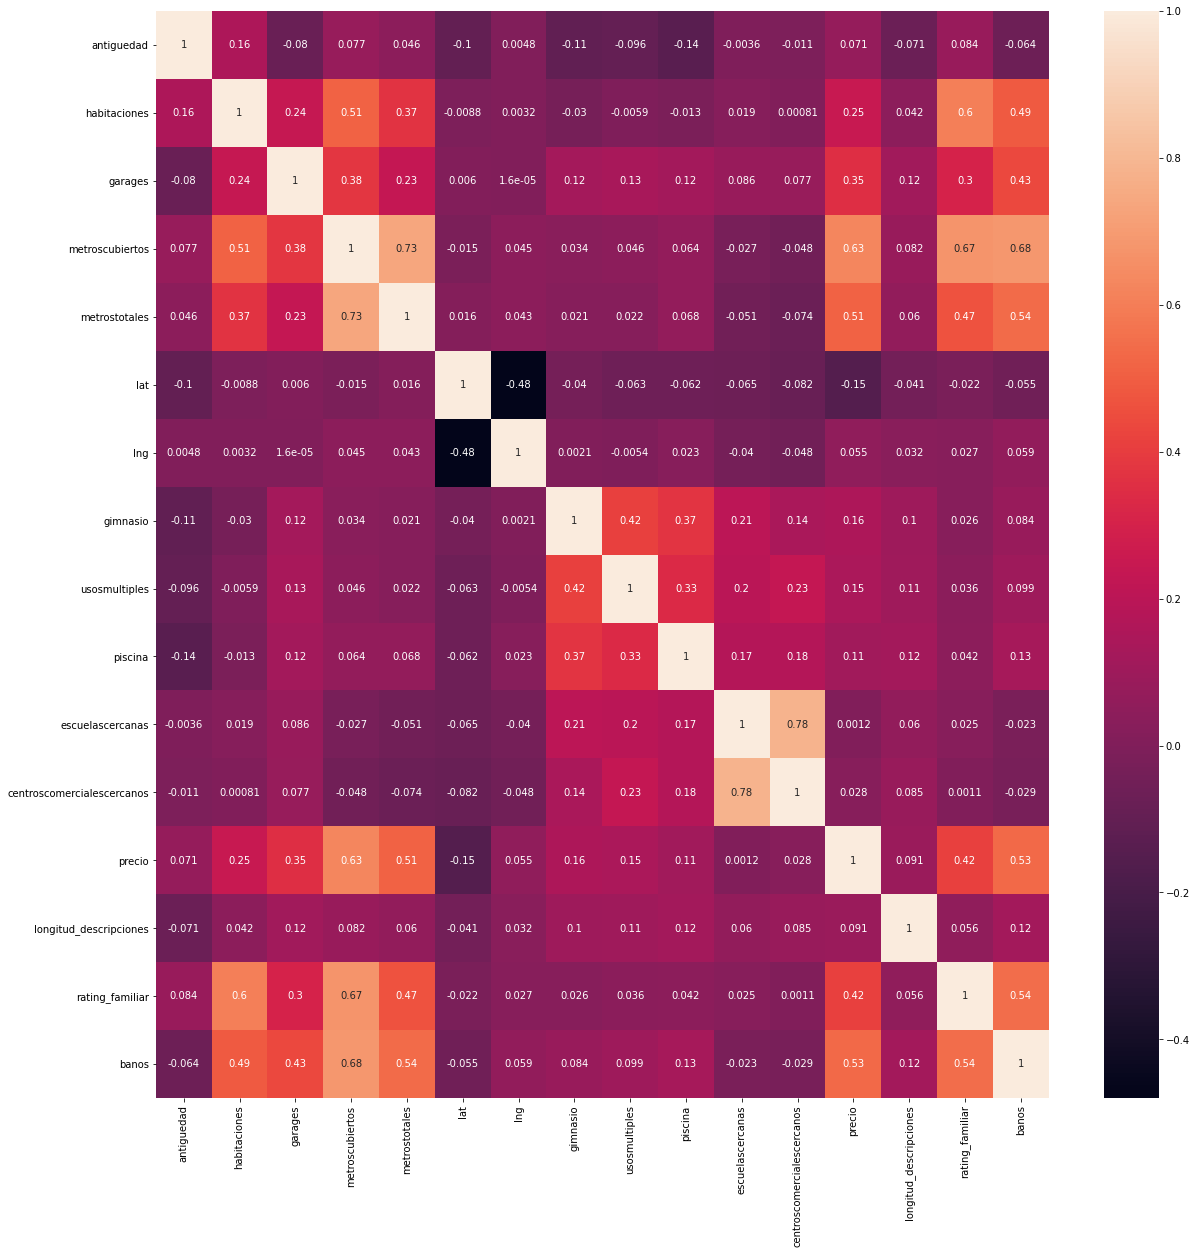

In [18]:
#Vemos la correlacion de estos nuevos features
plt.figure(figsize=(20, 20))
sns.heatmap(df_engineering.corr(), annot = True)
#long_descripciones tiene 0.12 y rating_familiar tiene 0.55

In [19]:
#Veamos como queda nuestro modelo usando las features con correlacion arriba de 0.25
utils.kFoldCrossValidation(df_engineering[['habitaciones','garages','metroscubiertos','metrostotales','precio','rating_familiar']],df_engineering['banos'])

[2.253074991687388, 1.1194692791706968]

In [20]:
#Preparamos el dataset para usar LASSO
#Nos quedamos solo con las no categoricas y dropeo los NaN
df_eng_lasso = df_engineering.copy()
df_eng_lasso = df_eng_lasso.dropna()
#Me guardo los banos y los features por separado
df_eng_lasso_banos = df_eng_lasso['banos']
df_eng_lasso.pop('banos')
print('Listo para usar Lasso!')

Listo para usar Lasso!


-0.0
0.0
0.0
0.004030600126114275
0.000887089102139681
0.0
-0.008738833430646397
0.0
0.0
0.0
0.0
0.0
1.282787900329562e-07
0.0005094255517751829
0.0008393228610440062


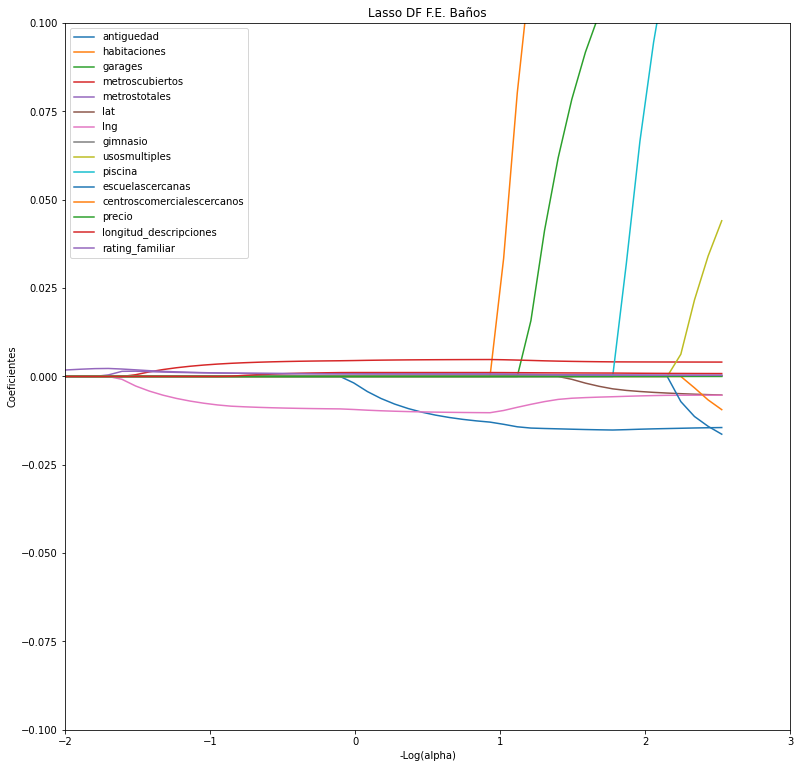

In [39]:
#Seteo colores
colors = cycle(['black', 'black', 'black', 'red', 'brown', 'yellow', 'black', 'black', 'black', 'black', 'black', 'black', 'orange','purple', 'green'])
plt.figure(figsize=(13, 13))

#Corremos Lasso para generar el path
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(df_eng_lasso,df_eng_lasso_banos / df_eng_lasso_banos.std(axis=0), eps = 5e-10, fit_intercept=False)
neg_log_alphas_lasso = -np.log10(alphas_lasso)

#Me guardo los plots segun curva
lineas = []
for coef_l, c in zip(coefs_lasso, colors):
    lineas.append(plt.plot(neg_log_alphas_lasso, coef_l))
    print(coef_l[65])

#Hago el plot
plt.xlabel('-Log(alpha)')
plt.ylabel('Coeficientes')
plt.title('Lasso DF F.E. Baños')
plt.legend(df_eng_lasso.columns.values)
plt.axis('tight')
plt.ylim(-0.1,0.1)
plt.xlim(-2,3)
plt.show()

In [22]:
#Nos quedamos con las 6 mejores features y corremos el modelo con estas
utils.kFoldCrossValidation(df_eng_lasso[['metroscubiertos','metrostotales','longitud_descripciones','rating_familiar','precio','lng']],df_eng_lasso_banos)

[0.6213490476746028, 0.20009894407134193]

In [23]:
#Segmentamos segun habitaciones
df_habitaciones = df_engineering.copy()
#Me quedo solo con las features de antes y banos
df_habitaciones = df_habitaciones[['habitaciones','metroscubiertos','metrostotales','longitud_descripciones','rating_familiar','lng','banos']]
#Dropeamos los NaN
df_habitaciones = df_habitaciones.dropna()
print('Dataset listo para usar!')

Dataset listo para usar!


In [41]:
df_habitaciones['habitaciones'].value_counts().head(3)

3.0    30929
2.0    13544
4.0     6179
Name: habitaciones, dtype: int64

In [25]:
#Me guardo dataframes segun cantidad de habitaciones (para las 3 que mas datos registrados hay)
df_3hab = df_habitaciones[df_habitaciones['habitaciones']==3].dropna().copy()
df_2hab = df_habitaciones[df_habitaciones['habitaciones']==2].dropna().copy()
df_4hab = df_habitaciones[df_habitaciones['habitaciones']==4].dropna().copy()
#Saco la columna habitaciones
df_3hab.pop('habitaciones')
df_2hab.pop('habitaciones')
df_4hab.pop('habitaciones')
#Me guardo la col. banos por separado
df_3hab_banos = df_3hab['banos']
df_2hab_banos = df_2hab['banos']
df_4hab_banos = df_4hab['banos']
#Saco banos de las features
df_3hab.pop('banos')
df_2hab.pop('banos')
df_4hab.pop('banos')

print('Listo para usar')

Listo para usar


In [26]:
#Modelo para 3 habitaciones
utils.kFoldCrossValidation(df_3hab,df_3hab_banos)

[0.3919139877336301, 0.13728685265397939]

In [27]:
#Modelo para 2 habitaciones
utils.kFoldCrossValidation(df_2hab,df_2hab_banos)

[0.44631688779853845, 0.17418121463906738]

In [28]:
#Modelo para 4 habitaciones
utils.kFoldCrossValidation(df_4hab,df_4hab_banos)

[0.29138946871057, 0.0968128396414342]

In [29]:
#Veamos como funciona para nuestro df de test
#Me quedo con las features conseguidas en el experimento previo
DF_TEST = DF_TEST[['habitaciones','metroscubiertos','metrostotales','longitud_descripciones','rating_familiar','lng','banos']]
DF_TEST = DF_TEST.dropna()
print('Dataset listo para usar!')

Dataset listo para usar!


In [30]:
DF_TEST['habitaciones'].value_counts().head(3)

3.0    13222
2.0     5795
4.0     2599
Name: habitaciones, dtype: int64

In [31]:
#Me guardo dataframes segun cantidad de habitaciones (para las 3 que mas datos registrados hay)
DF_TEST_3hab = DF_TEST[DF_TEST['habitaciones']==3].dropna().copy()
DF_TEST_2hab = DF_TEST[DF_TEST['habitaciones']==2].dropna().copy()
DF_TEST_4hab = DF_TEST[DF_TEST['habitaciones']==4].dropna().copy()
#Saco la columna habitaciones
DF_TEST_3hab.pop('habitaciones')
DF_TEST_2hab.pop('habitaciones')
DF_TEST_4hab.pop('habitaciones')
#Me guardo la col. banos por separado
DF_TEST_3hab_banos = DF_TEST_3hab['banos']
DF_TEST_2hab_banos = DF_TEST_2hab['banos']
DF_TEST_4hab_banos = DF_TEST_4hab['banos']
#Saco banos de las features
DF_TEST_3hab.pop('banos')
DF_TEST_2hab.pop('banos')
DF_TEST_4hab.pop('banos')

print('Listo para usar')

Listo para usar


In [32]:
#Modelo para 3 habitaciones
utils.kFoldCrossValidation(DF_TEST_3hab,DF_TEST_3hab_banos)

[0.38781585244721917, 0.13597179857845892]

In [33]:
#Modelo para 2 habitaciones
utils.kFoldCrossValidation(DF_TEST_2hab,DF_TEST_2hab_banos)

[0.44479133651052816, 0.17337234646476002]

In [34]:
#Modelo para 4 habitaciones
utils.kFoldCrossValidation(DF_TEST_4hab,DF_TEST_4hab_banos)

[0.2947611063457913, 0.09909578670740825]